# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

**Description of the data**
```
/datasets/imdb_reviews.tsv
Features:
    review — the review text
    ds_part — 'train'/'test' for the train/test part of dataset, correspondingly
Target:
    pos – '0' for negative and '1' for positive
```

## Initialization

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('wordnet')
import spacy

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Load Data

In [5]:
try:
    df_reviews_raw = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', na_values=r'\N', dtype={'votes': 'Int64'})
except:
    df_reviews_raw = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', na_values=r'\N', dtype={'votes': 'Int64'})

In [6]:
df_reviews_raw.info()
display(df_reviews_raw.describe())
display(df_reviews_raw.describe(include='object'))
df_reviews_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         2279 non-null   float64
 6   runtime_minutes  46843 non-null  float64
 7   is_adult         47331 non-null  int64  
 8   genres           47305 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,start_year,end_year,runtime_minutes,is_adult,average_rating,votes,rating,pos,idx
count,47331.000,2279.000,46843.000,47331.000,47329.000,47329.000,47331.000,47331.000,47331.000
mean,1989.631,1999.540,98.760,0.002,5.998,25562.917,5.485,0.499,6279.698
std,19.600,11.846,38.323,0.042,1.494,83670.039,3.473,0.500,3605.703
min,1894.000,1953.000,1.000,0.000,1.400,9.000,1.000,0.000,0.000
25%,1982.000,1995.000,87.000,0.000,5.100,827.000,2.000,0.000,3162.000
50%,1998.000,2004.000,95.000,0.000,6.300,3197.000,4.000,0.000,6299.000
75%,2004.000,2008.000,109.000,0.000,7.100,13974.000,9.000,1.000,9412.000
max,2010.000,2020.000,1140.000,1.000,9.700,1739448.000,10.000,1.000,12499.000


,tconst,title_type,primary_title,original_title,genres,review,sp,ds_part
count,47331,47331,47331,47331,47305,47331,47331,47331
unique,6648,10,6555,6562,584,47240,2,2
top,tt0067445,movie,The Sentinel,The Sentinel,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,3392,5,23715,23796


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,NaN,121.000,0,"Comedy,Crime,Drama",6.300,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,NaN,121.000,0,"Comedy,Crime,Drama",6.300,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,NaN,25.000,0,"Comedy,Drama,Short",6.300,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,NaN,25.000,0,"Comedy,Drama,Short",6.300,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,NaN,25.000,0,"Comedy,Drama,Short",6.300,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews = df_reviews_raw[['tconst', 'start_year', 'review', 'rating', 'pos', 'ds_part']]

df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tconst      47331 non-null  object
 1   start_year  47331 non-null  int64 
 2   review      47331 non-null  object
 3   rating      47331 non-null  int64 
 4   pos         47331 non-null  int64 
 5   ds_part     47331 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


,tconst,start_year,review,rating,pos,ds_part
0,tt0068152,1971,The pakage implies that Warren Beatty and Gold...,1,0,train
1,tt0068152,1971,How the hell did they get this made?! Presenti...,1,0,train
2,tt0313150,2002,There is no real story the film seems more lik...,3,0,test
3,tt0313150,2002,Um .... a serious film about troubled teens in...,7,1,test
4,tt0313150,2002,I'm totally agree with GarryJohal from Singapo...,9,1,test


In [8]:
print(f'Duplicates in data: {df_reviews.duplicated().sum()} ({(df_reviews.duplicated().sum() / df_reviews.shape[0]):.2%})')
df_reviews.drop_duplicates(keep=False, inplace=True, ignore_index=True)

Duplicates in data: 85 (0.18%)


**Conclusion**  
Using common sense and domain knowledge, we extracted the features that could be useful for exploring the data and constructing the models.  
Also, we dropped 85 duplicates.

## EDA

Let's check the number of movies and reviews over years.

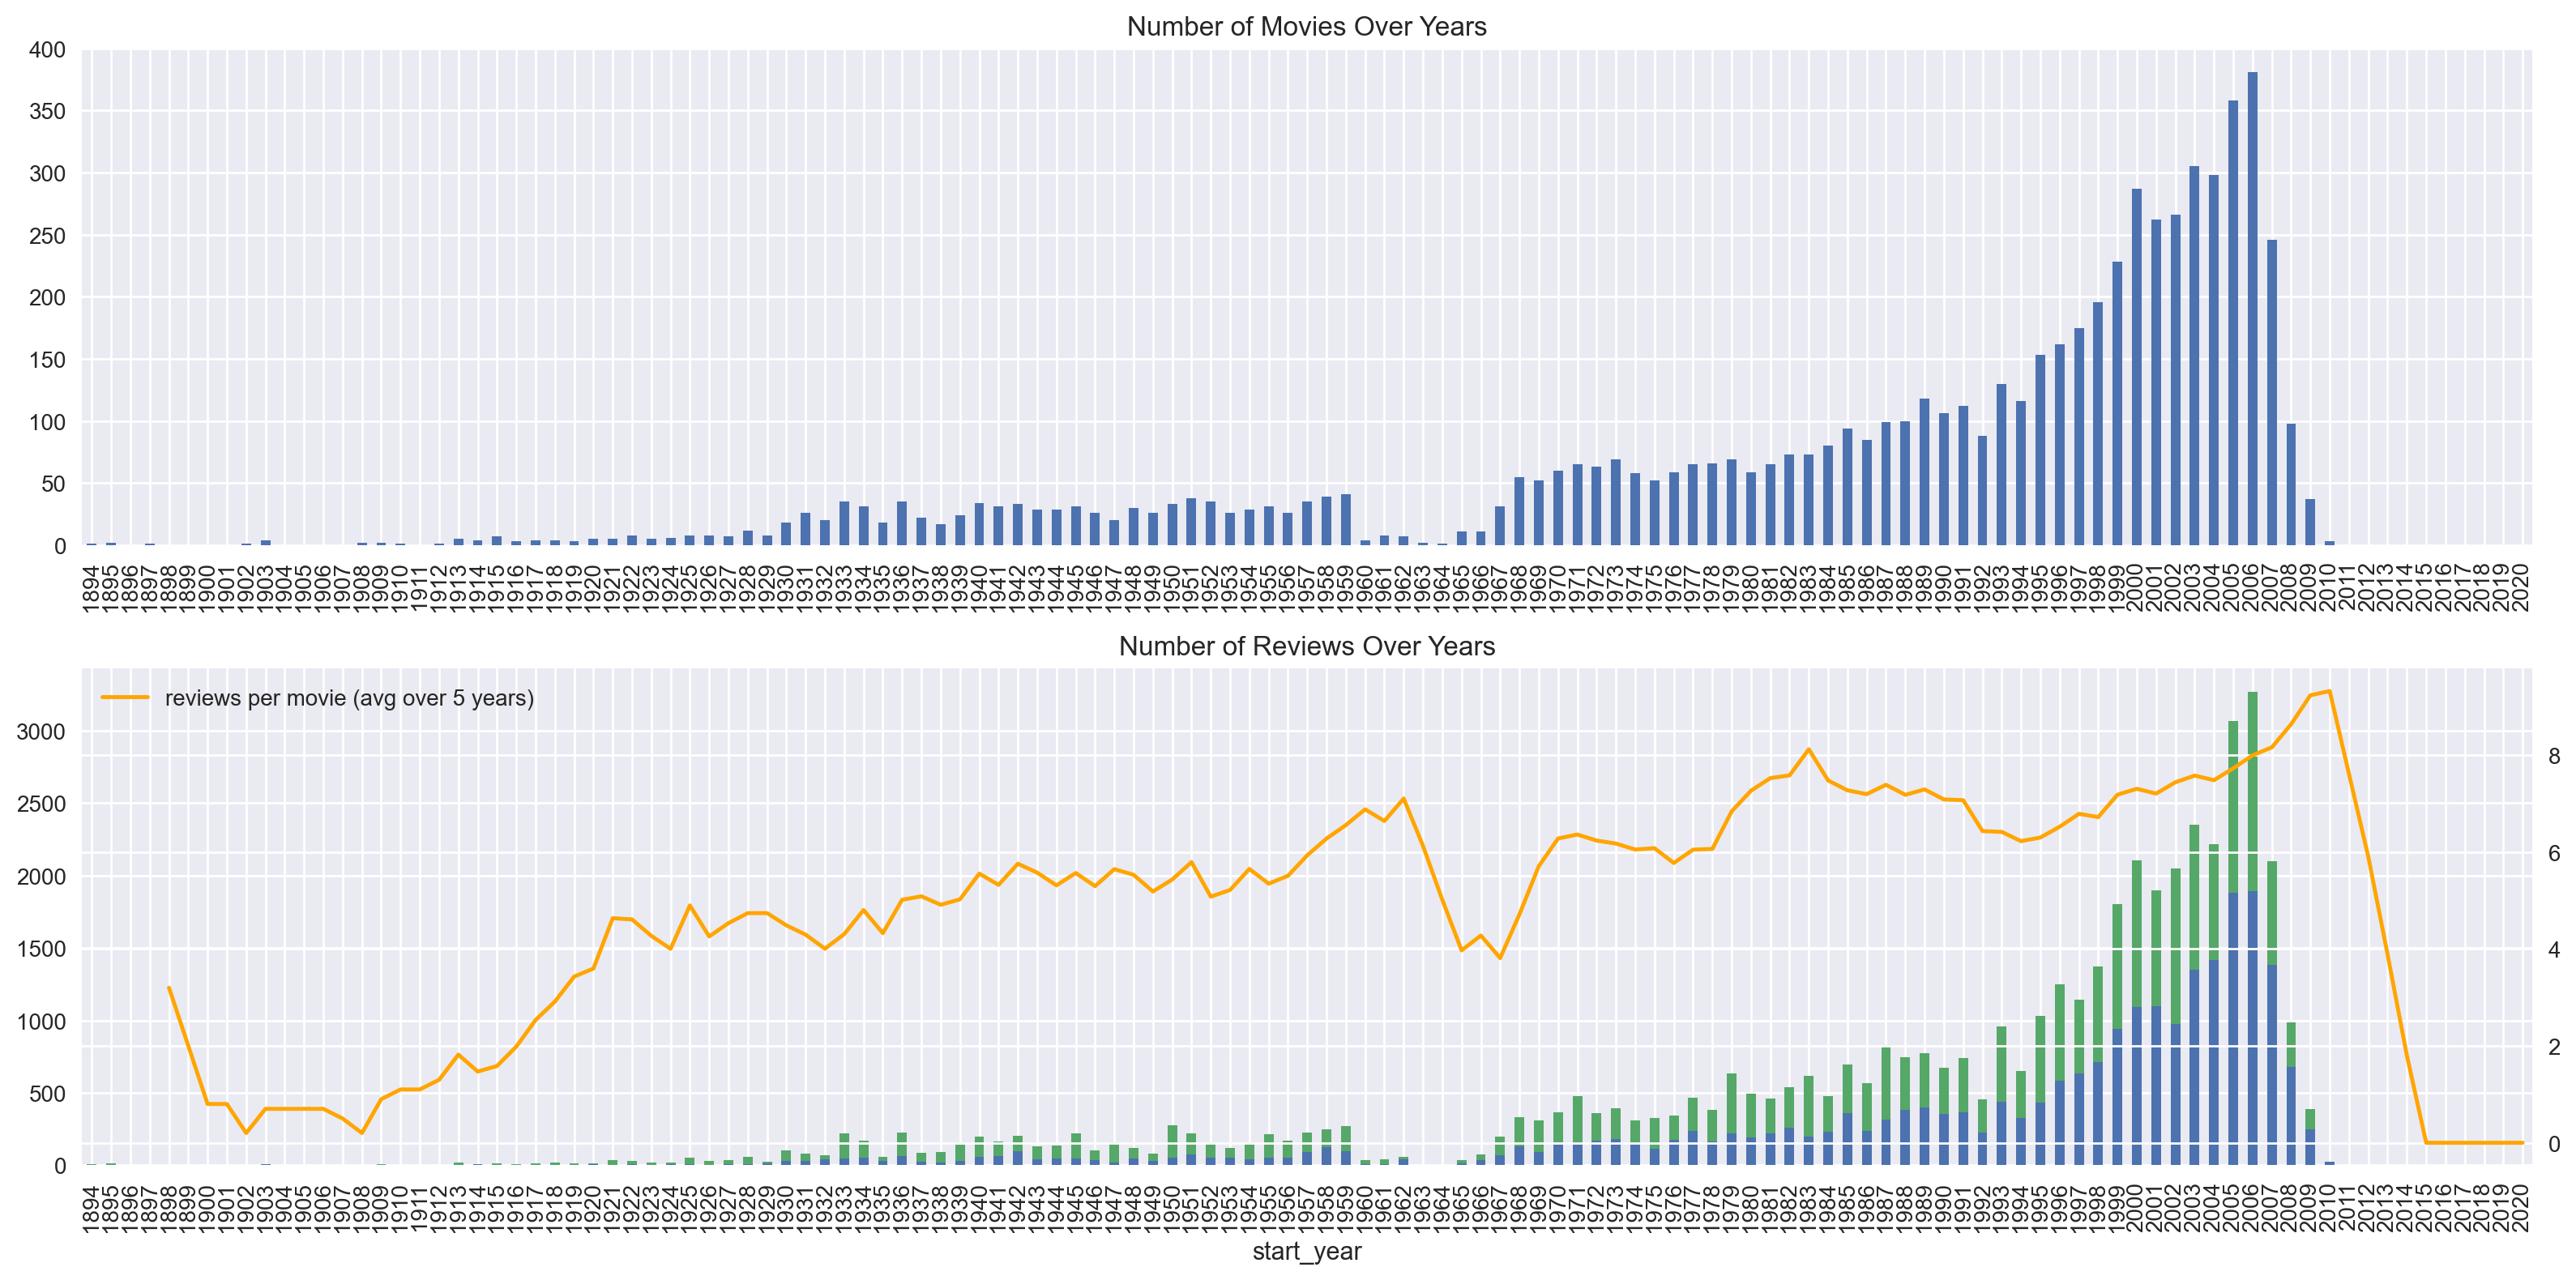

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

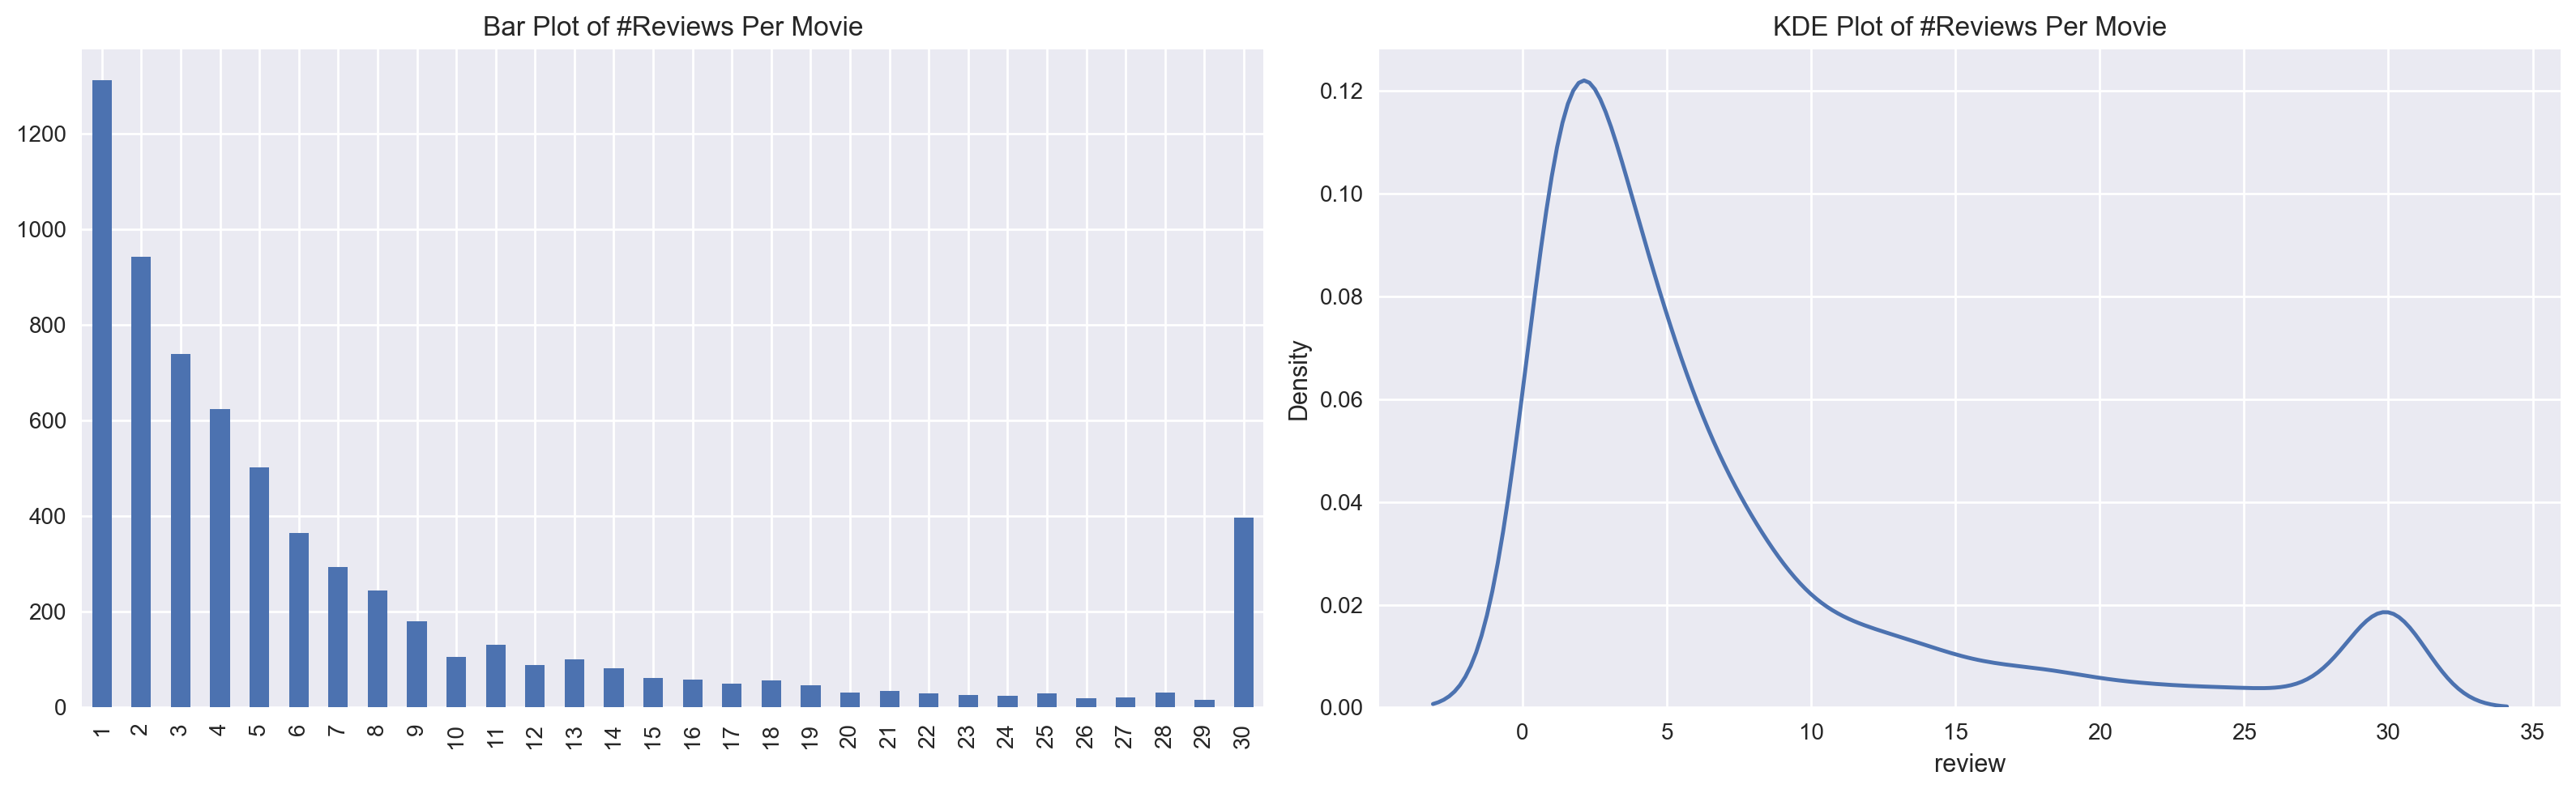

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Conclusion**  
The majority of movies have less than ten reviews. But also there is a significant amount of films with 30 reviews. I suppose that if there were more than 30 reviews for a movie, they were excluded from the dataset.

In [11]:
df_reviews['pos'].value_counts()

0    23652
1    23518
Name: pos, dtype: int64

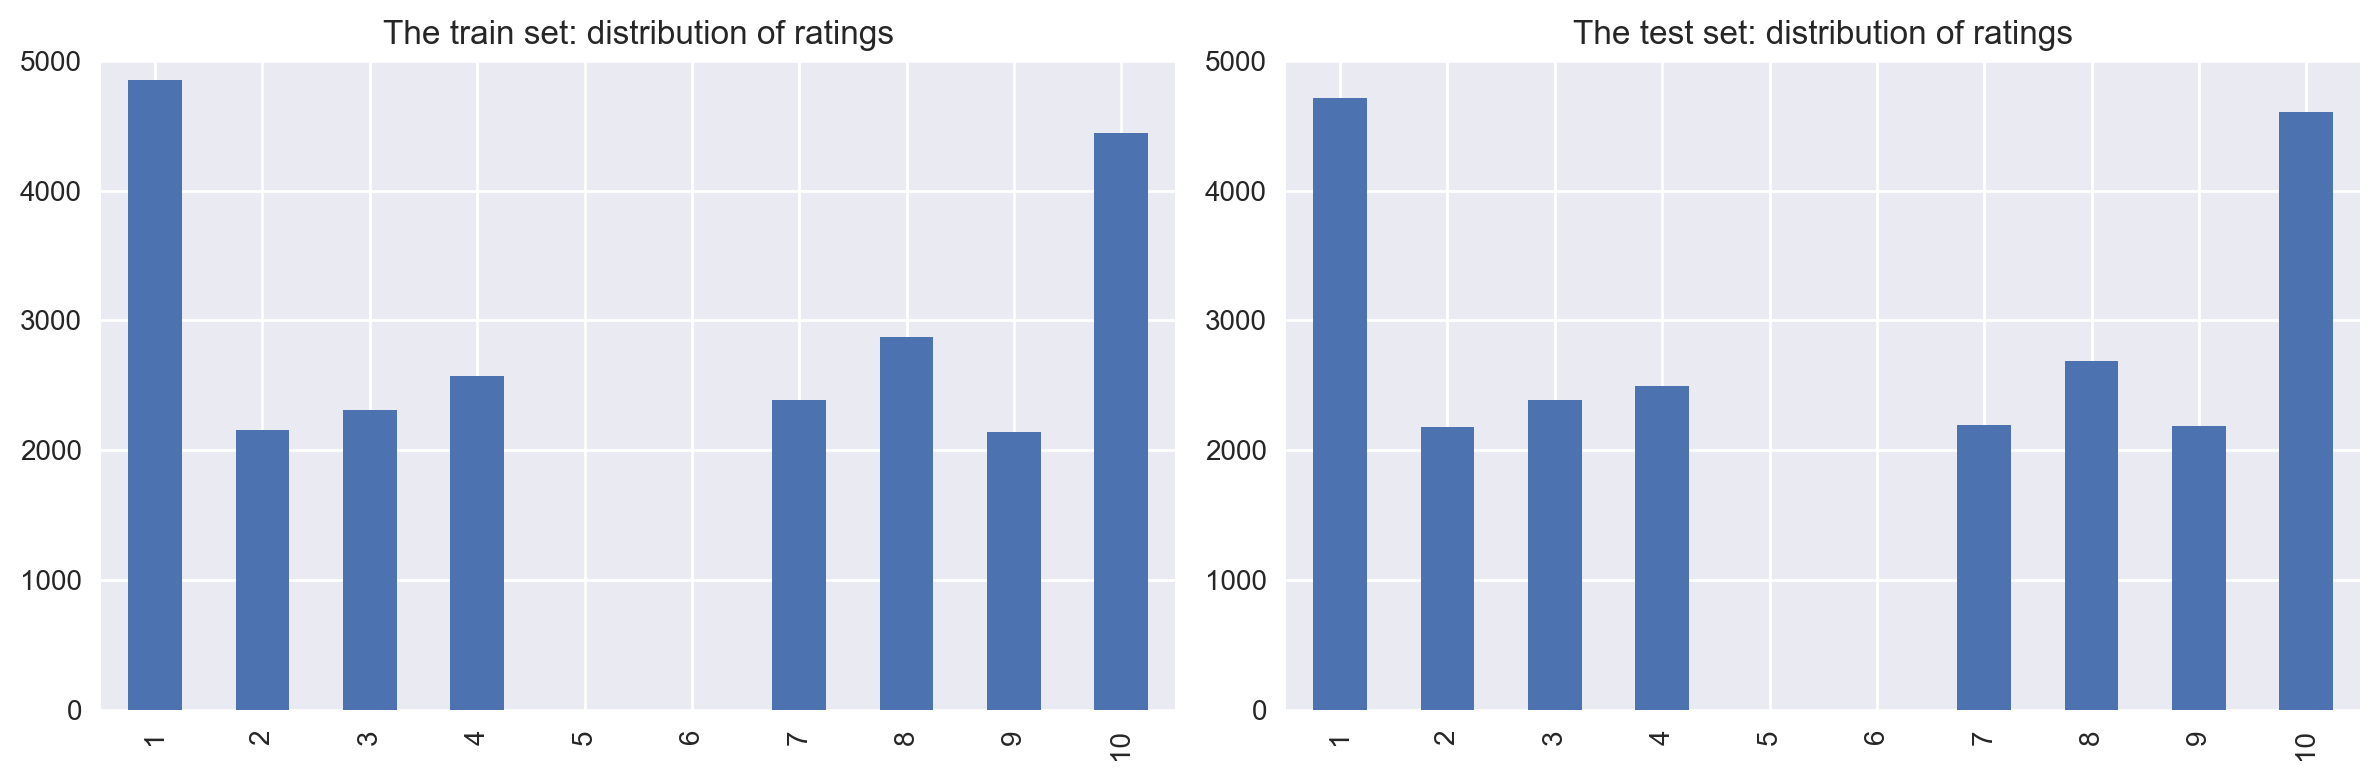

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

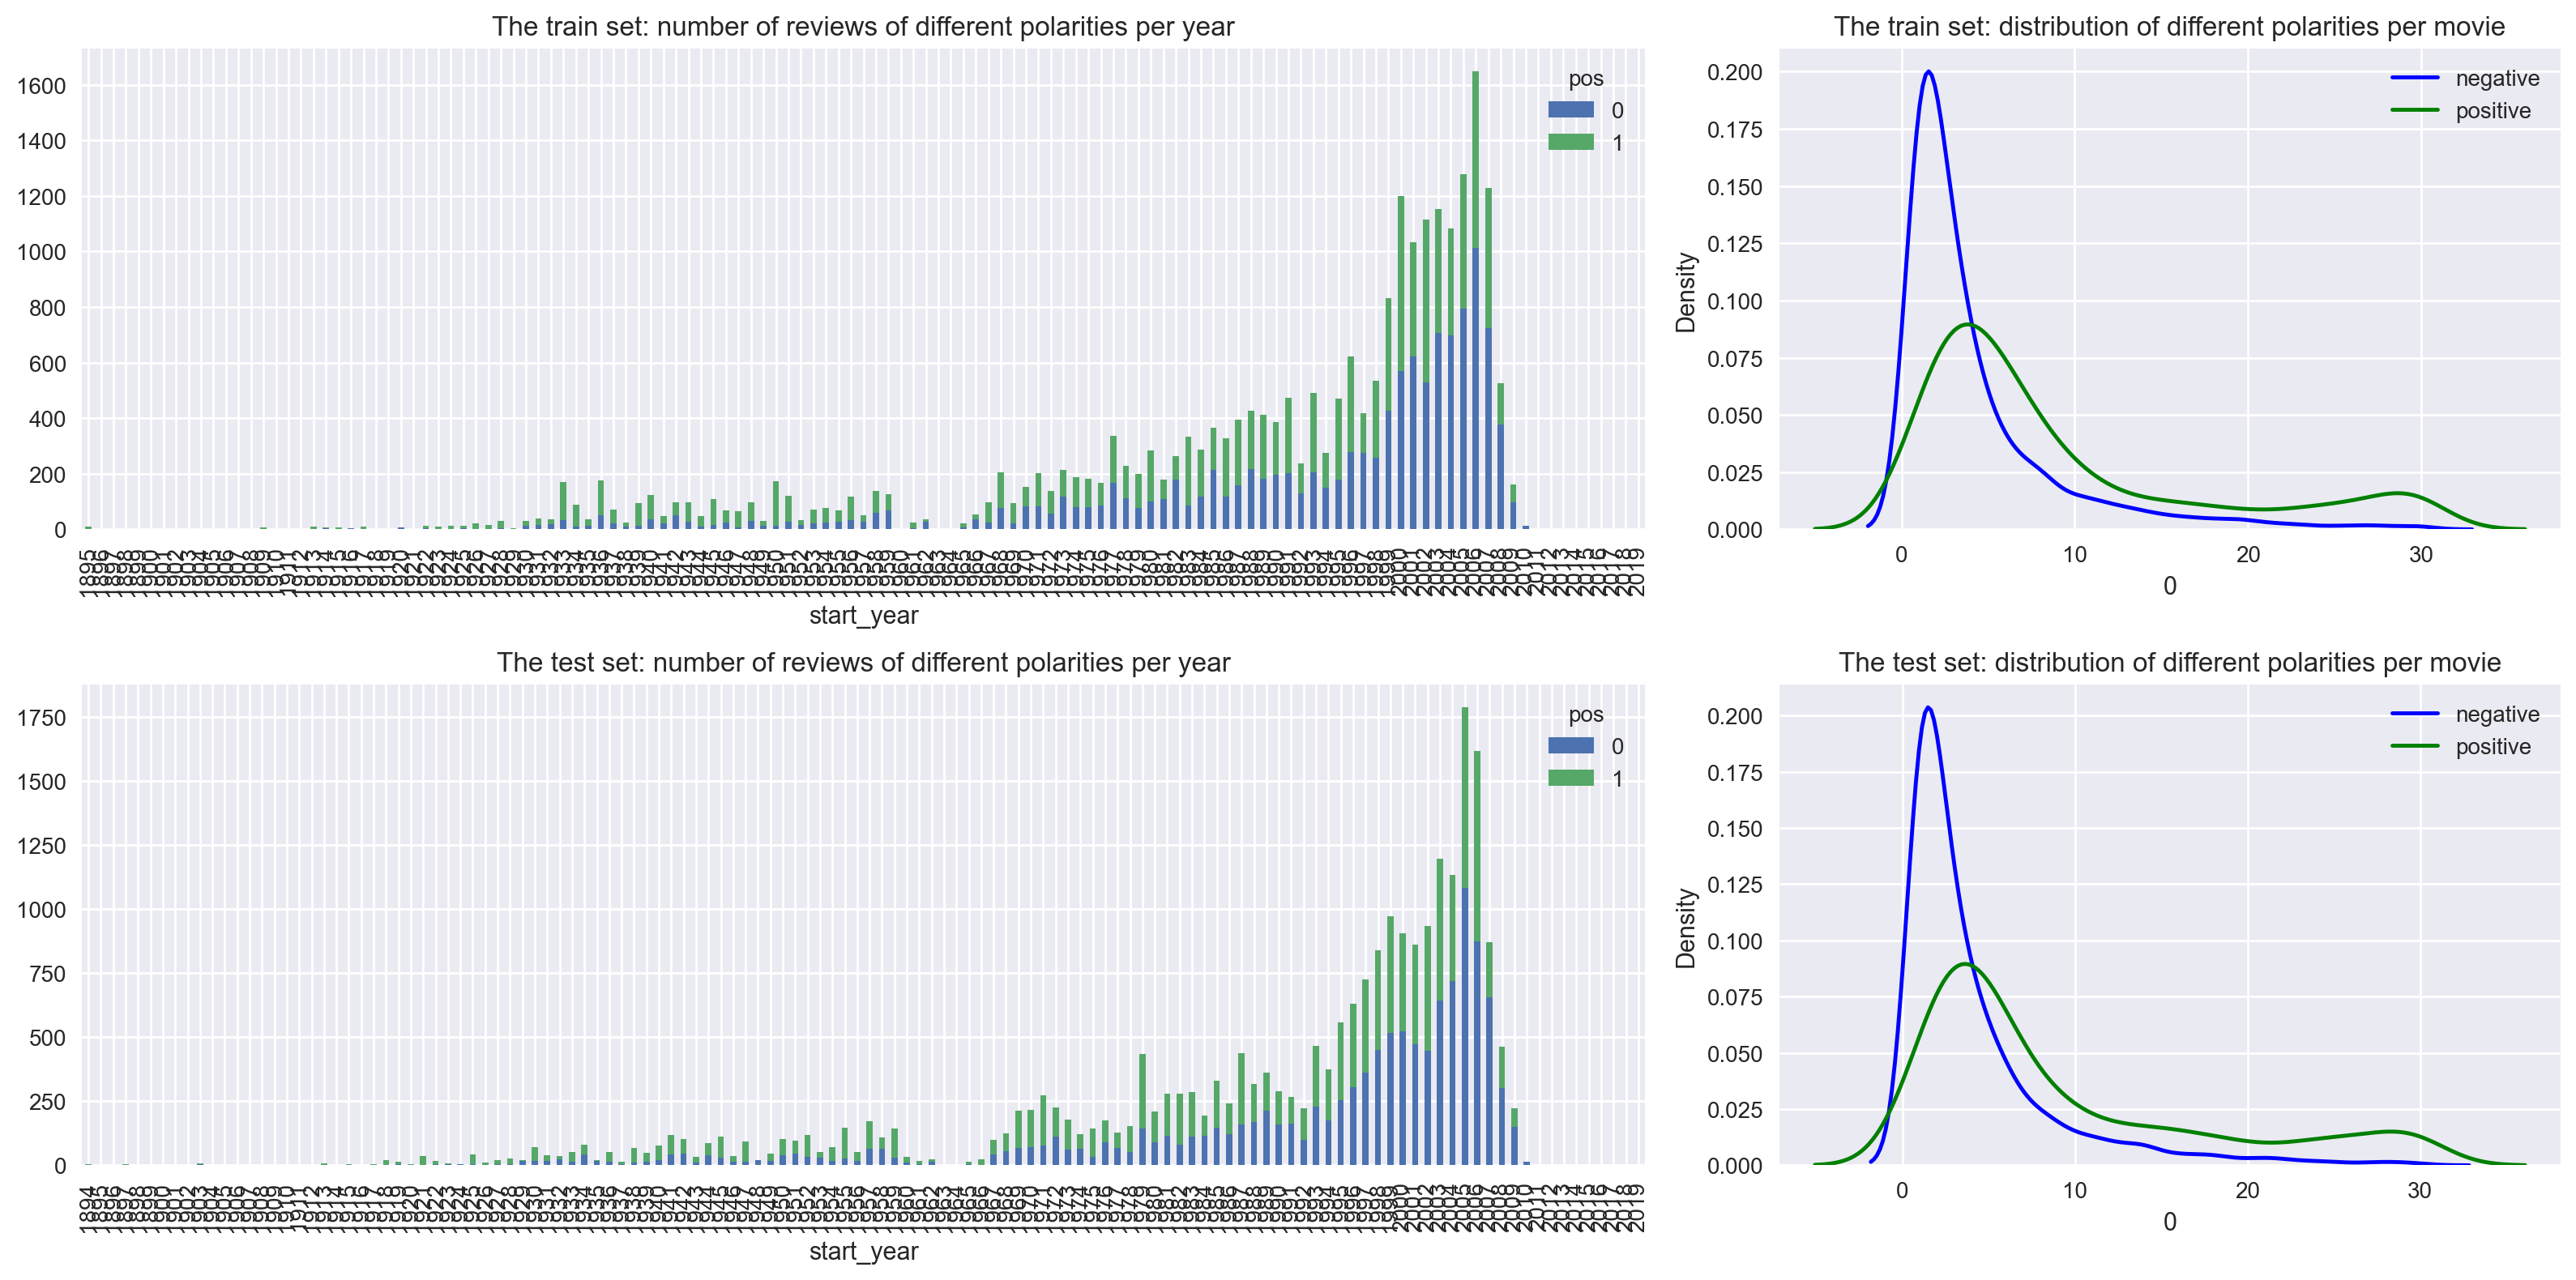

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Conclusion**  
We don't have a class imbalance here, and positive and negative reviews are distributed equally between the train and test parts.  
Also, the most frequent ratings are 0 or 10, and we don't have ratings any of 5 or 6. So I suppose we are dealing with a very artificial dataset.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-zA-z\'\s]', '')
df_reviews.head()

,tconst,start_year,review,rating,pos,ds_part,review_norm
0,tt0068152,1971,The pakage implies that Warren Beatty and Gold...,1,0,train,the pakage implies that warren beatty and gold...
1,tt0068152,1971,How the hell did they get this made?! Presenti...,1,0,train,how the hell did they get this made presenting...
2,tt0313150,2002,There is no real story the film seems more lik...,3,0,test,there is no real story the film seems more lik...
3,tt0313150,2002,Um .... a serious film about troubled teens in...,7,1,test,um a serious film about troubled teens in sin...
4,tt0313150,2002,I'm totally agree with GarryJohal from Singapo...,9,1,test,i'm totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23725, 7)
(23445, 7)


## Working with models

### Model 1 - Constant

          train  test
Accuracy  0.500 0.500
F1        0.000 0.000
APS       0.500 0.500
ROC AUC   0.500 0.500


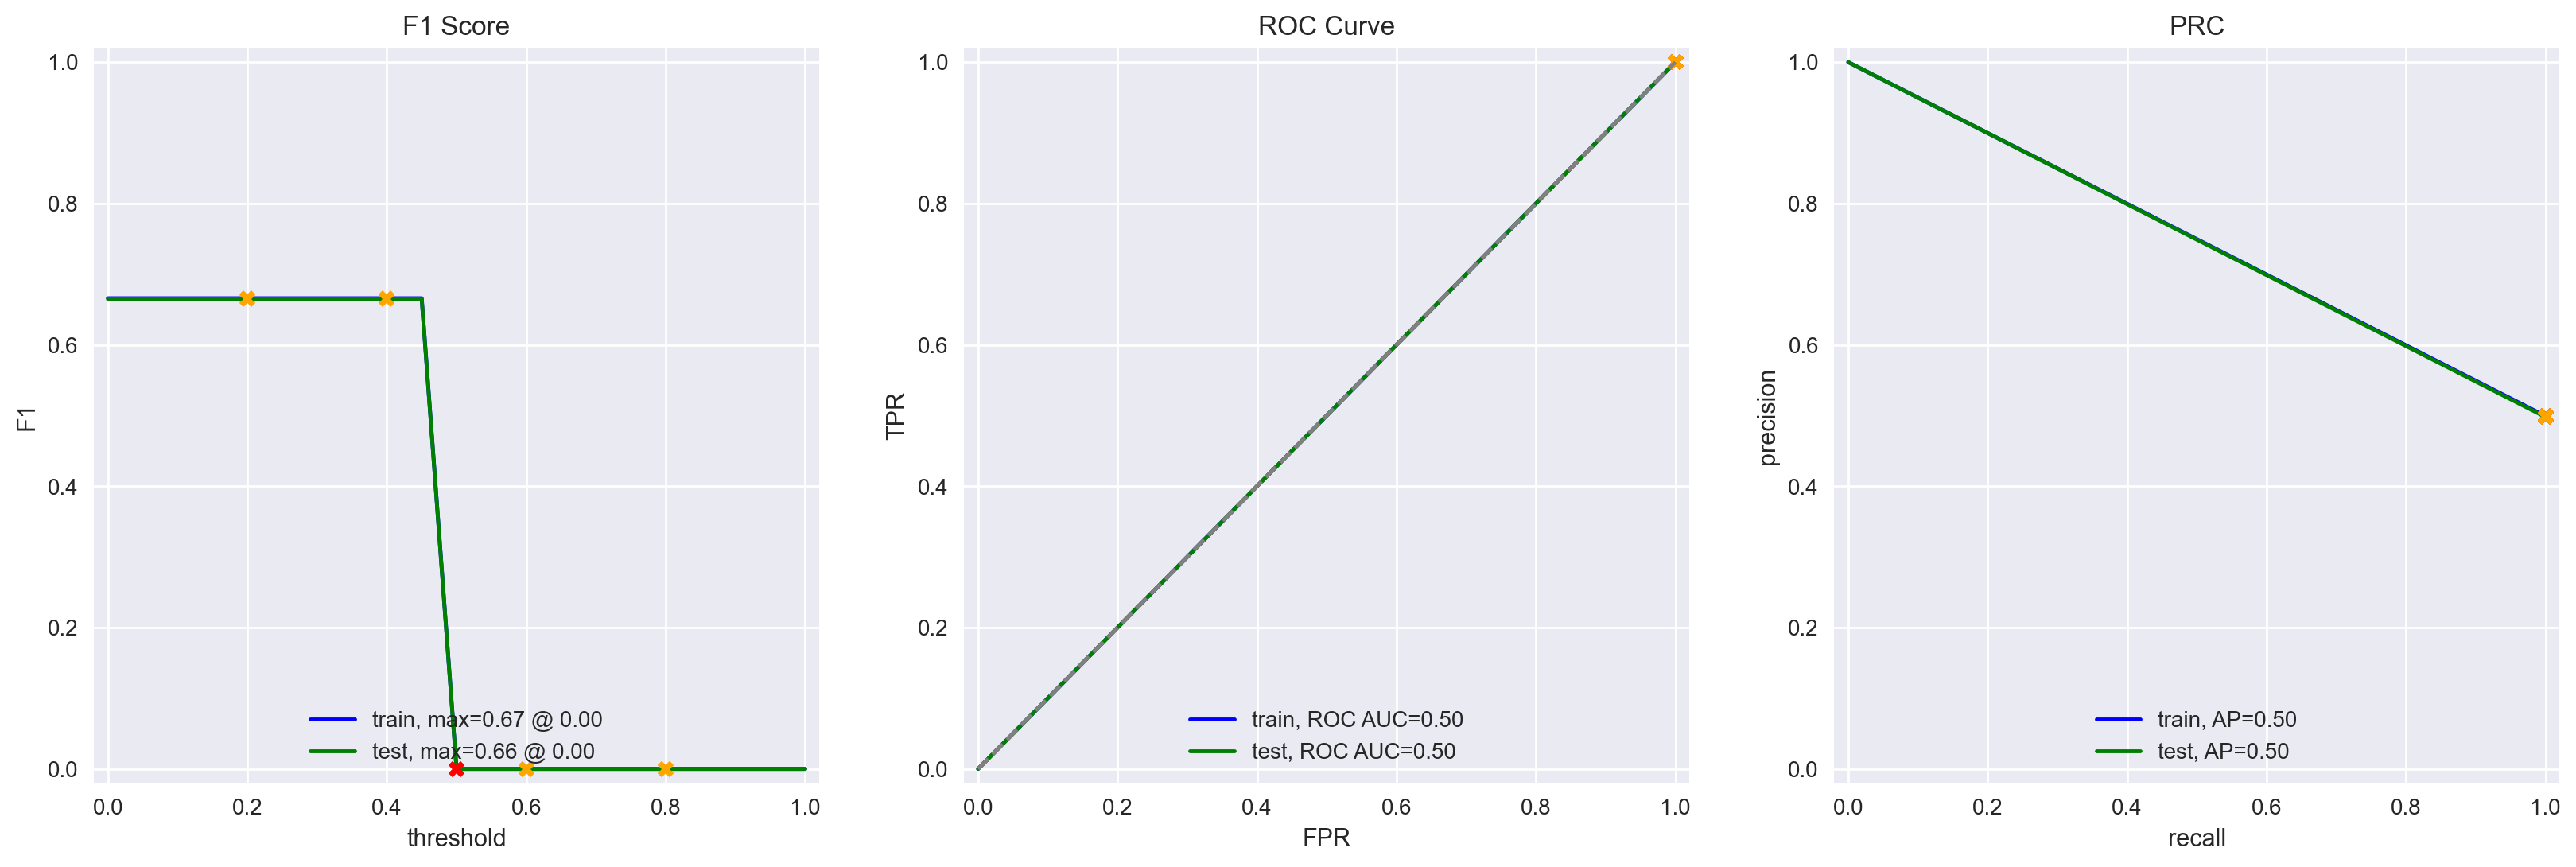

In [17]:
dummy_model = DummyClassifier().fit(df_reviews_train, train_target)

evaluate_model(dummy_model, df_reviews_train, train_target, df_reviews_test, test_target)

### Model 2 - NLTK, TF-IDF and LR

In [18]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def text_preprocessing_2(text):
    lemmas = [lemmatizer.lemmatize(token) for token in nltk.tokenize.word_tokenize(text)]    
    return ' '.join(lemmas)

In [19]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_2))
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'].apply(text_preprocessing_2))

print('The train TF-IDF matrix size:', train_features_2.shape)
print('The test TF-IDF matrix size:', test_features_2.shape)

The train TF-IDF matrix size: (23725, 94002)
The test TF-IDF matrix size: (23445, 94002)


          train  test
Accuracy  0.940 0.880
F1        0.940 0.880
APS       0.980 0.950
ROC AUC   0.980 0.950


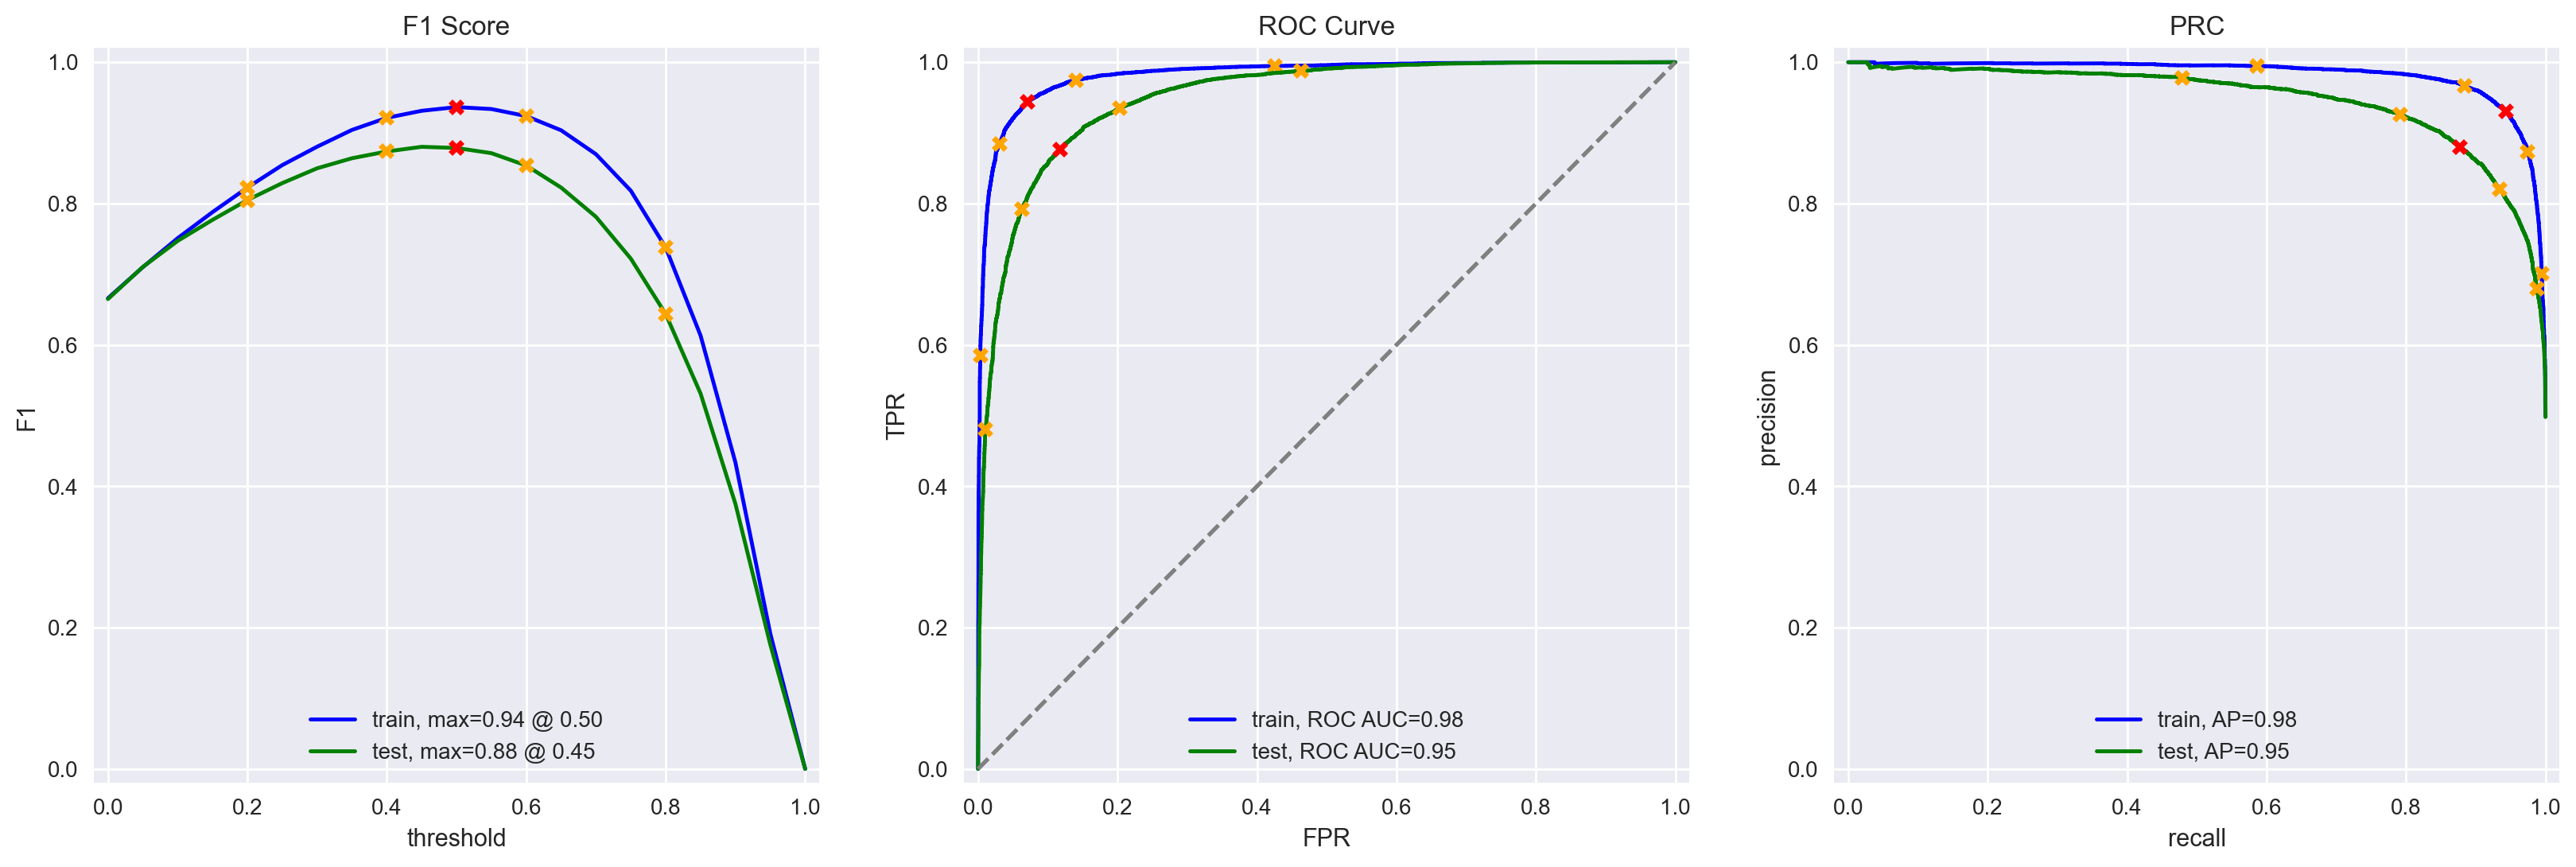

In [20]:
model_2 = LogisticRegression(random_state=42, solver='liblinear')
model_2.fit(train_features_2, train_target)
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    lemmas = [token.lemma_ for token in nlp(text)]
    return ' '.join(lemmas)

In [22]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm'].apply(text_preprocessing_3))
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm'].apply(text_preprocessing_3))

print('The train TF-IDF matrix size:', train_features_3.shape)
print('The test TF-IDF matrix size:', test_features_3.shape)

The train TF-IDF matrix size: (23725, 88669)
The test TF-IDF matrix size: (23445, 88669)


          train  test
Accuracy  0.930 0.880
F1        0.930 0.880
APS       0.980 0.950
ROC AUC   0.980 0.950


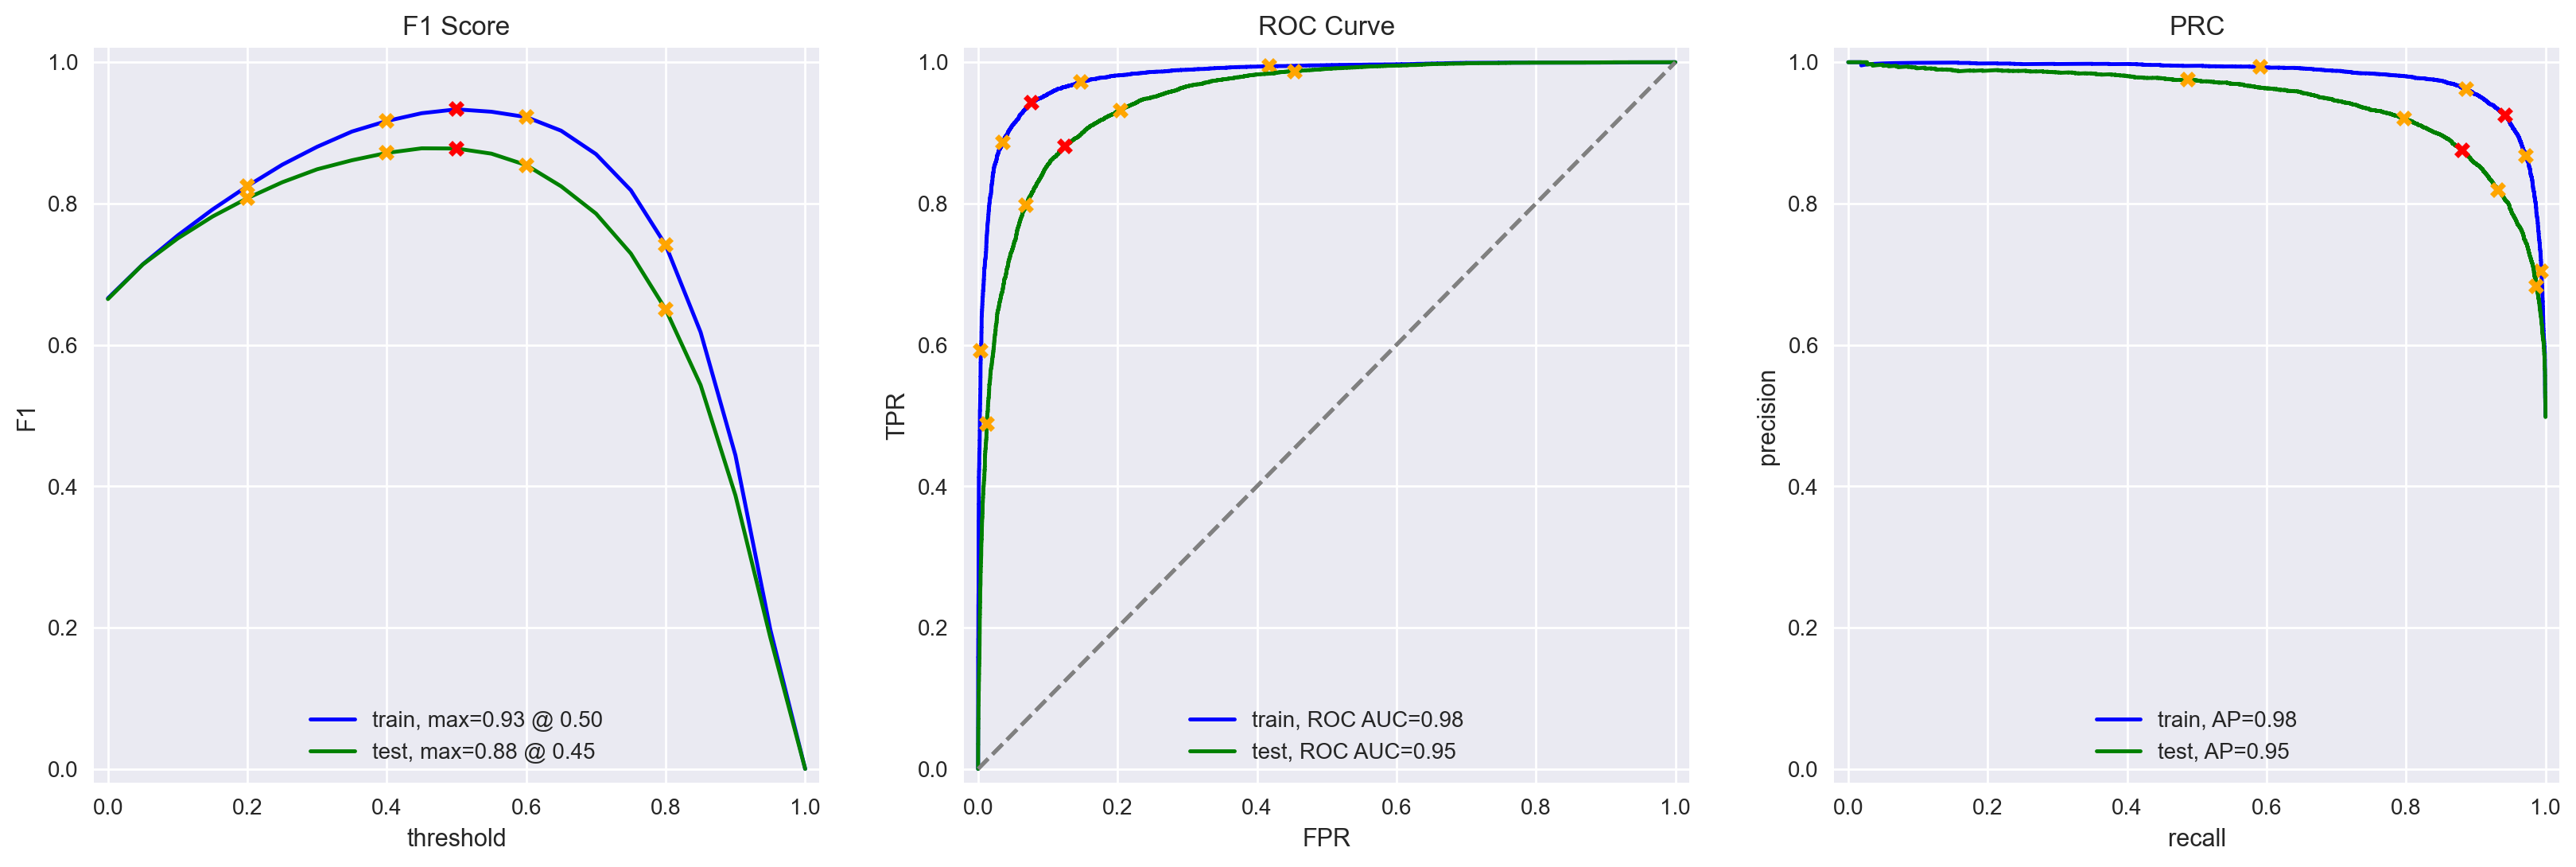

In [23]:
model_3 = LogisticRegression(random_state=42, solver='liblinear')
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

Grid search for LGBM Classifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best LGBM parameters: {'n_estimators': 200, 'num_leaves': 51}
          train  test
Accuracy  0.990 0.870
F1        0.990 0.870
APS       1.000 0.940
ROC AUC   1.000 0.940


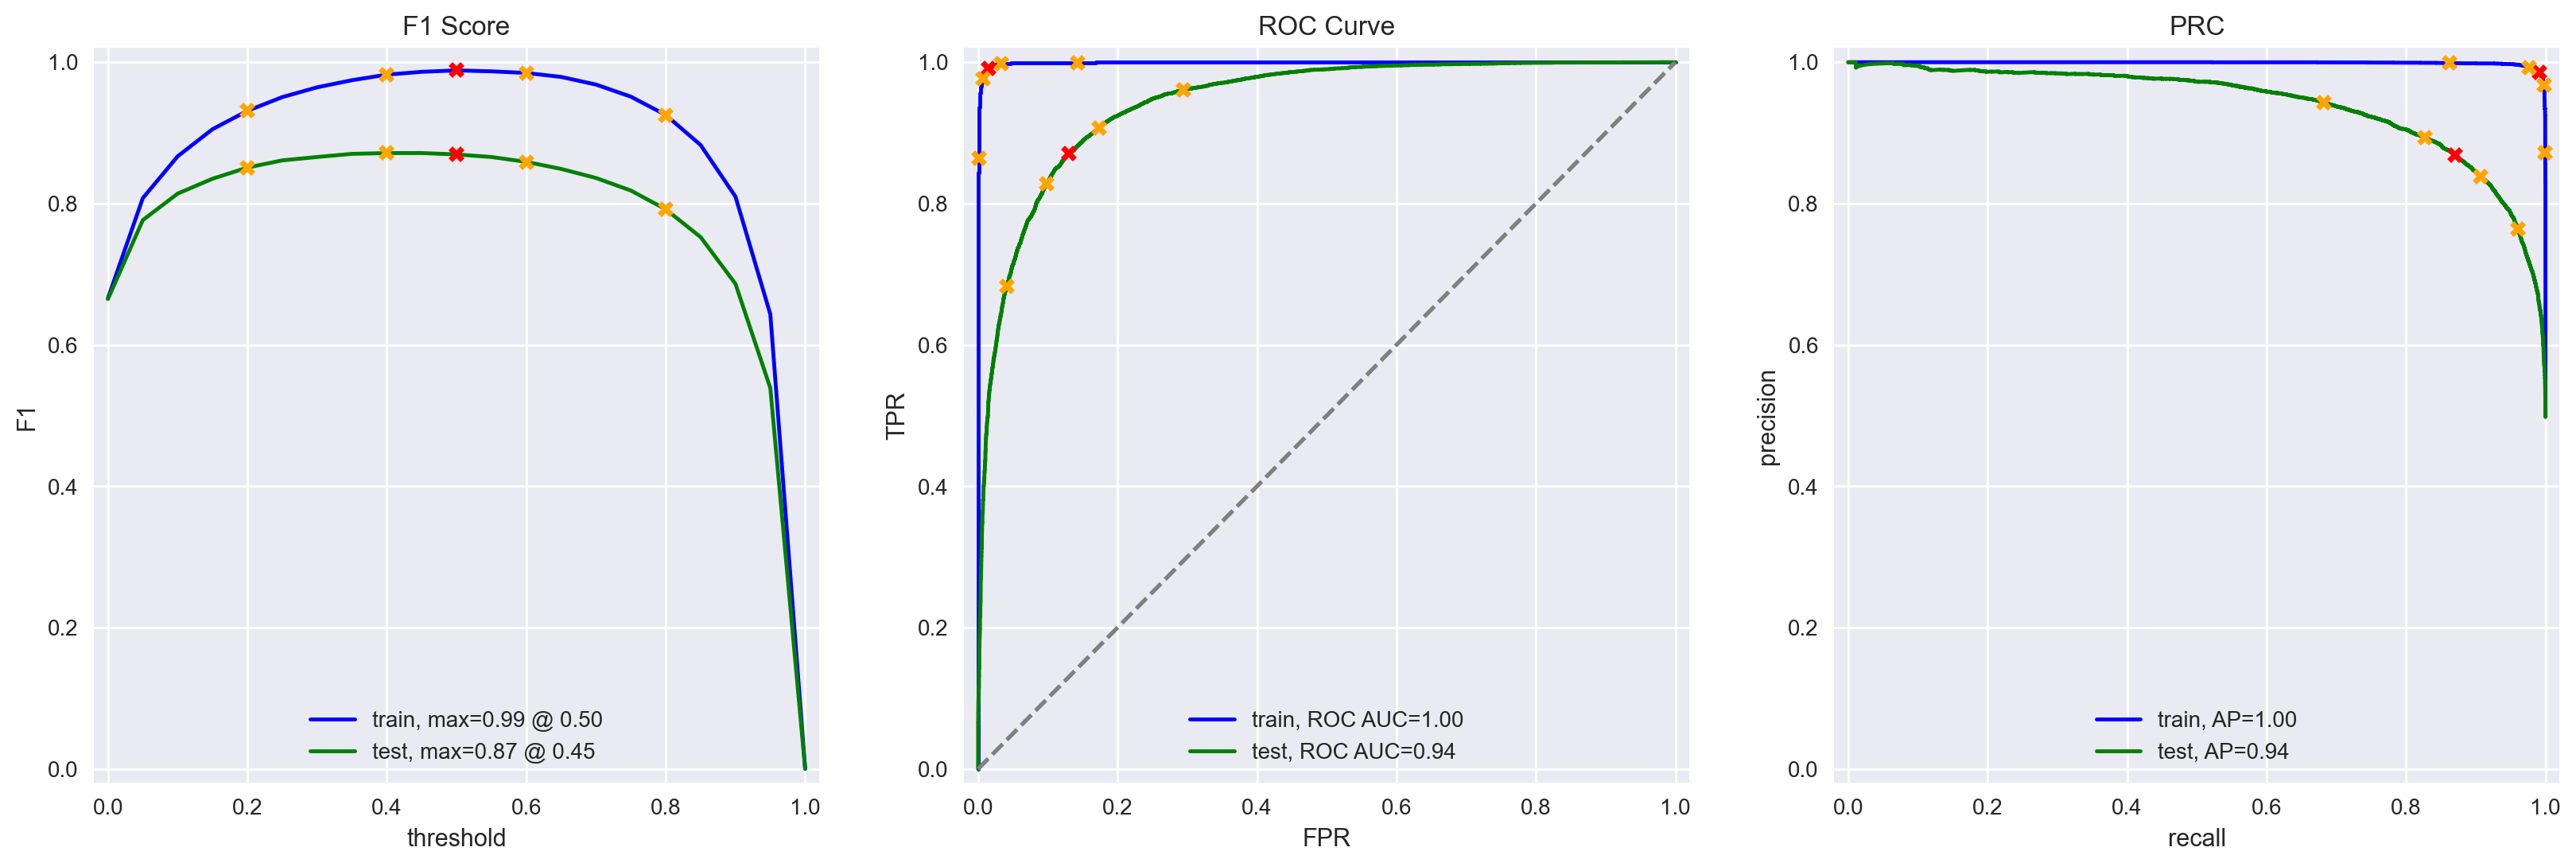

In [24]:
model_4 = LGBMClassifier(random_state=42,)
parameters = {'num_leaves' : [31, 51], 'n_estimators': [100, 200]}
    
print("Grid search for LGBM Classifier")
lgbm_best = GridSearchCV(model_4, parameters, cv=3, verbose=1)
lgbm_best.fit(train_features_3, train_target)
print()
print(f"Best LGBM parameters: {lgbm_best.best_params_}")
evaluate_model(lgbm_best, train_features_3, train_target, test_features_3, test_target)

## My Reviews

In [25]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r'[^a-zA-z\'\s]', '')
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 2

In [26]:
my_reviews_pred_prob_2 = model_2.predict_proba(tfidf_vectorizer_2.transform(my_reviews['review_norm'].apply(text_preprocessing_2)))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.47:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [27]:
my_reviews_pred_prob_3 = model_3.predict_proba(tfidf_vectorizer_3.transform(my_reviews['review_norm'].apply(text_preprocessing_3)))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.13:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [28]:
my_reviews_pred_prob_4 = lgbm_best.predict_proba(tfidf_vectorizer_3.transform(my_reviews['review_norm'].apply(text_preprocessing_3)))[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.54:  i did not simply like it not my kind of movie
0.25:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.77:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.14:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

In this project, we explored a dataset of IMBD movie reviews with polarity labelling and built a model for classifying positive and negative reviews.  
We tried two lemmatization methods (using nltk and spacy), vectorized our texts with TF-IDF and built a Logistic Regression model and an LGBM Classifier.  
Our best model uses  NLTK, TF-IDF and LogisticRegression. It shows an F1 score of 0.88 on the test set. Also, it is significantly faster than the other two methods.